In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import cv2
import re
from tensorflow.keras.models import load_model
import pandas as pd

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train='/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'
valid='/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/'

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 38  # NUMBER OF CLASSES
EPOCHS = 45

In [ ]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1/255.0,
    preprocessing_function=None,
    validation_split=0.1,
)
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)


In [ ]:
train_generator = train_datagen.flow_from_directory(train,
                      batch_size=BATCH_SIZE,
                      target_size=(IMAGE_SIZE, IMAGE_SIZE),
                      subset="training",
                      color_mode='rgb',
                      class_mode='categorical',  # using 'categorical' as multiclass classification
                      shuffle=True)

valid_generator = valid_datagen.flow_from_directory(
    valid,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)


Found 63282 images belonging to 38 classes.
Found 1742 images belonging to 38 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer, fine_tune=0):
    base=VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)
    for layer in base.layers:
        layer.trainable=False
    top = base.output
    top=layers.Flatten(name="flatten")(top)
    top=layers.Dense(4096, activation='relu')(top)
    top=layers.Dense(1072, activation='relu')(top)
    top=layers.Dropout(0.2)(top)
    output=layers.Dense(n_classes, activation='softmax')(top)

    model=models.Model(inputs=base.input, outputs=output)
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'f1_score', 'precision'])
    return model

In [ ]:
input_shape=(224,224,3)
optim=tf.keras.optimizers.Adam(learning_rate=1e-4)
vgg=create_model(input_shape, 38, optim, fine_tune=0)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
checkpoint=ModelCheckpoint(filepath='best_vgg16_plant_disease.keras', save_best_only=True, verbose=1)
early_stop=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

### Model Training

In [ ]:
history = vgg.fit(
    train_generator,
    epochs = 10,
    validation_data = valid_generator,
    validation_steps = valid_generator.samples // BATCH_SIZE,
    callbacks = [checkpoint, early_stop]
)


Epoch 1/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.6672 - f1_score: 0.6652 - loss: 1.1645 - precision: 0.8537
Epoch 1: val_loss improved from inf to 0.41804, saving model to best_vgg16_plant_disease.keras
989/989 ━━━━━━━━━━━━━━━━━━━━ 973s 954ms/step - accuracy: 0.6673 - f1_score: 0.6653 - loss: 1.1640 - precision: 0.8537 - val_accuracy: 0.8663 - val_f1_score: 0.8651 - val_loss: 0.4180 - val_precision: 0.9014
Epoch 2/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.8874 - f1_score: 0.8870 - loss: 0.3428 - precision: 0.9186
Epoch 2: val_loss improved from 0.41804 to 0.18965, saving model to best_vgg16_plant_disease.keras
989/989 ━━━━━━━━━━━━━━━━━━━━ 775s 778ms/step - accuracy: 0.8874 - f1_score: 0.8870 - loss: 0.3428 - precision: 0.9186 - val_accuracy: 0.9286 - val_f1_score: 0.0253 - val_loss: 0.1896 - val_precision: 0.9286
Epoch 3/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.9115 - f1_score: 0.9112 - loss: 0.2607 - precision: 0.9316
Epoch 3: va

## Plotting graphs

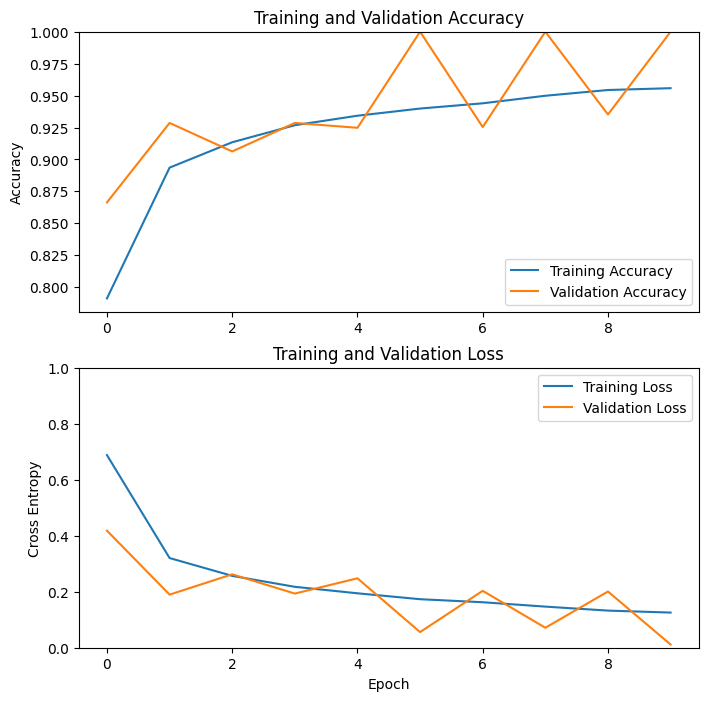

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

# Plot Training & Validation Accuracy
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Plot Training & Validation Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()


###  loading model

In [ ]:
model=models.load_model("/kaggle/working/best_vgg16_plant_disease.keras")

In [ ]:
class_dict = train_generator.class_indices
df_labels = pd.DataFrame(
    list(class_dict.items()),
    columns=['class_name', 'class_index']
)

def remove_underscores_and_capitalize(s):
    parts = s.split('_')
    parts = [p for p in parts if p]
    if not parts:
        return s
    result = parts[0]
    for p in parts[1:]:
        if p:
            result += p[0].upper() + p[1:]
    return result
df_labels['class_name'] = df_labels['class_name'].apply(remove_underscores_and_capitalize)
print(df_labels)

                                    class_name  class_index
0                               AppleAppleScab            0
1                                AppleBlackRot            1
2                          AppleCedarAppleRust            2
3                                 AppleHealthy            3
4                             BlueberryHealthy            4
5           Cherry(includingSour)PowderyMildew            5
6                 Cherry(includingSour)Healthy            6
7   Corn(maize)CercosporaLeafSpot GrayLeafSpot            7
8                        Corn(maize)CommonRust            8
9                Corn(maize)NorthernLeafBlight            9
10                          Corn(maize)Healthy           10
11                               GrapeBlackRot           11
12                     GrapeEsca(BlackMeasles)           12
13         GrapeLeafBlight(IsariopsisLeafSpot)           13
14                                GrapeHealthy           14
15         OrangeHaunglongbing(CitrusGre

In [ ]:
df_labels['class_name'] = df_labels['class_name'].replace({
    'AppleCedarAppleRust': 'AppleCedarRust',
    'AppleAppleScab': 'AppleScab',
    'Corn(maize)CommonRust': 'CornCommonRust',
    'TomatoTomatoYellowLeafCurlVirus': 'TomatoYellowCurlVirus'
})


In [ ]:
df_labels

,class_name,class_index
0,AppleScab,0
1,AppleBlackRot,1
2,AppleCedarRust,2
3,AppleHealthy,3
4,BlueberryHealthy,4
5,Cherry(includingSour)PowderyMildew,5
6,Cherry(includingSour)Healthy,6
7,Corn(maize)CercosporaLeafSpot GrayLeafSpot,7
8,CornCommonRust,8
9,Corn(maize)NorthernLeafBlight,9


In [ ]:
test_dir = "/kaggle/input/new-plant-diseases-dataset/test/test"
test_filenames = sorted([
    f for f in os.listdir(test_dir)
    if f.lower().endswith((".jpg", ".png"))
])

correct = 0
total = len(test_filenames)

for fname in test_filenames:
    # Remove extension
    name_no_ext = os.path.splitext(fname)[0]
    label_str = re.sub(r"\d+", "", name_no_ext)
    label_str = label_str.replace("_", "")
    row_matches = df_labels[df_labels['class_name'] == label_str]
    true_class_index = int(row_matches['class_index'].iloc[0])
    img_path = os.path.join(test_dir, fname)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    img_batch = np.expand_dims(img, axis=0)  # shape: (1, 224, 224, 3)
    preds = model.predict(img_batch, verbose=0)  # shape: (1, num_classes)
    pred_class_index = np.argmax(preds[0])
    if pred_class_index == true_class_index:
        correct += 1
#Compute accuracy
accuracy = correct / total if total > 0 else 0
print(f"Accuracy on test_images: {accuracy*100:.2f}%")

Accuracy on test_images: 78.79%
